# Download churn dataset

In [1]:
import os
os.environ["TF_METAL_ENABLED"] = "0"          # por si acaso
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"     # inofensivo en Mac, fuerza CPU
import tensorflow as tf, numpy as np
print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TF: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
!kaggle datasets list -s telco-customer-churn

ref                                                              title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
blastchar/telco-customer-churn                                   Telco Customer Churn                                    175758  2018-02-23 18:20:00.210000         389490       3149  0.88235295       
abdallahwagih/telco-customer-churn                               Telco Customer Churn                                   1314646  2024-10-11 05:27:55.330000           2351         49  0.88235295       
alfathterry/telco-customer-churn-11-1-3                          Telco customer churn (11.1.3+)                          525781  2024-05-08 20:46:56.010000           3583         55  1.0          

In [3]:
from utils.paths import DATA_RAW_DIR, DATA_INTERIM_DIR, DATA_PROCESSED_DIR, MODELS_DIR

In [4]:
!kaggle datasets download -d blastchar/telco-customer-churn -p {DATA_RAW_DIR} --unzip

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0%|                                                | 0.00/172k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 444MB/s]


# import libraries

In [43]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.models import load_model
from keras.callbacks import EarlyStopping

# load dataset

In [8]:
from pathlib import Path

path_churn = DATA_RAW_DIR / "WA_Fn-UseC_-Telco-Customer-Churn.csv"
print(path_churn.exists())

True


In [9]:
df_churn = pd.read_csv(path_churn, sep=",", encoding="utf-8")
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

In [10]:
df_churn.describe(include="all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [11]:
# summary with pandas

def summarize_dataframe(df):
    summary = df.describe(include="all").T
    summary['type'] = df.dtypes
    summary['unique_values'] = df.nunique()
    summary["missing_values"] = df.isnull().sum()
    summary['examples'] = df.apply(lambda col: col.dropna().unique()[:3])\

    summary = summary[['type', 'unique_values', 'missing_values', 'examples']]
    return summary



In [12]:
summary = summarize_dataframe(df_churn)
summary

,type,unique_values,missing_values,examples
customerID,object,7043,0,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK]"
gender,object,2,0,"[Female, Male]"
SeniorCitizen,int64,2,0,"[0, 1]"
Partner,object,2,0,"[Yes, No]"
Dependents,object,2,0,"[No, Yes]"
tenure,int64,73,0,"[1, 34, 2]"
PhoneService,object,2,0,"[No, Yes]"
MultipleLines,object,3,0,"[No phone service, No, Yes]"
InternetService,object,3,0,"[DSL, Fiber optic, No]"
OnlineSecurity,object,3,0,"[No, Yes, No internet service]"


In [13]:
from ydata_profiling import ProfileReport

ProfileReport(df_churn, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 1275.34it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
df_churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [15]:
# remove unnecessary columns customerID and gender
df_churn = df_churn.drop(columns=["customerID", "gender"])

In [16]:
# check missing values?
df_churn.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
df_churn.Churn

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

# label encoder

In [18]:
print(df_churn.shape)
print(df_churn.columns)

(7043, 19)
Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'],
      dtype='object')


In [19]:
df_churn.dtypes

SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [20]:
# Define categorical columns
categorical_cols = df_churn.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [21]:
# replace Yes with 1 and No with 0 in categorical columns
df_churn[categorical_cols] = df_churn[categorical_cols].replace({'Yes': 1, 'No': 0})


In [22]:
df_churn.head(15)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
5,0,0,0,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,Electronic check,99.65,820.5,1
6,0,0,1,22,1,1,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),89.10,1949.4,0
7,0,0,0,10,0,No phone service,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,29.75,301.9,0
8,0,1,0,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,Electronic check,104.80,3046.05,1
9,0,0,1,62,1,0,DSL,1,1,0,0,0,0,One year,0,Bank transfer (automatic),56.15,3487.95,0


In [23]:
df_churn.dtypes

SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [24]:
df_churn.head(10)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
5,0,0,0,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,Electronic check,99.65,820.5,1
6,0,0,1,22,1,1,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),89.10,1949.4,0
7,0,0,0,10,0,No phone service,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,29.75,301.9,0
8,0,1,0,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,Electronic check,104.80,3046.05,1
9,0,0,1,62,1,0,DSL,1,1,0,0,0,0,One year,0,Bank transfer (automatic),56.15,3487.95,0


In [25]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_churn[col] = le.fit_transform(df_churn[col].astype(str))  
    label_encoders[col] = le

In [26]:
joblib.dump(label_encoders, MODELS_DIR / "label_encoders.pkl")

['/Users/jasonssdev/Dev/Learning/Platzi/platzi-deeplearning/models/label_encoders.pkl']

In [27]:
scale_cols = ['tenure','MonthlyCharges','TotalCharges']

scale = MinMaxScaler()
df_churn[scale_cols] = scale.fit_transform(df_churn[scale_cols])

In [28]:
df_churn.head(15)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0.013889,0,2,1,0,1,0,0,0,0,0,1,2,0.115423,0.383614,0
1,0,0,0,0.472222,1,0,1,1,0,1,0,0,0,1,0,3,0.385075,0.224502,0
2,0,0,0,0.027778,1,0,1,1,1,0,0,0,0,0,1,3,0.354229,0.024043,1
3,0,0,0,0.625000,0,2,1,1,0,1,1,0,0,1,0,0,0.239303,0.214395,0
4,0,0,0,0.027778,1,0,2,0,0,0,0,0,0,0,1,2,0.521891,0.141654,1
5,0,0,0,0.111111,1,1,2,0,0,1,0,1,1,0,1,2,0.809950,0.934763,1
6,0,0,1,0.305556,1,1,2,0,1,0,0,1,0,0,1,1,0.704975,0.237366,0
7,0,0,0,0.138889,0,2,1,1,0,0,0,0,0,0,0,3,0.114428,0.399541,0
8,0,1,0,0.388889,1,1,2,0,0,1,1,1,1,0,1,2,0.861194,0.405207,1
9,0,0,1,0.861111,1,0,1,1,1,0,0,0,0,1,0,0,0.377114,0.462787,0


In [29]:
df_churn.shape

(7043, 19)

In [30]:
df_churn.dtypes

SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure              float64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [31]:
joblib.dump(scale, MODELS_DIR / "scaler.pkl")

['/Users/jasonssdev/Dev/Learning/Platzi/platzi-deeplearning/models/scaler.pkl']

# entrenamiento

In [32]:
# split data
X = df_churn.drop("Churn", axis=1)
y = df_churn["Churn"]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5634, 18) (5634,) (1409, 18) (1409,)


# neural network

In [34]:
# define columns/feature

num_features = len(X.columns)
num_features

18

In [35]:
# define sequential model
model_sequential = keras.Sequential(
    [
        keras.layers.Input(shape=(num_features,)),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

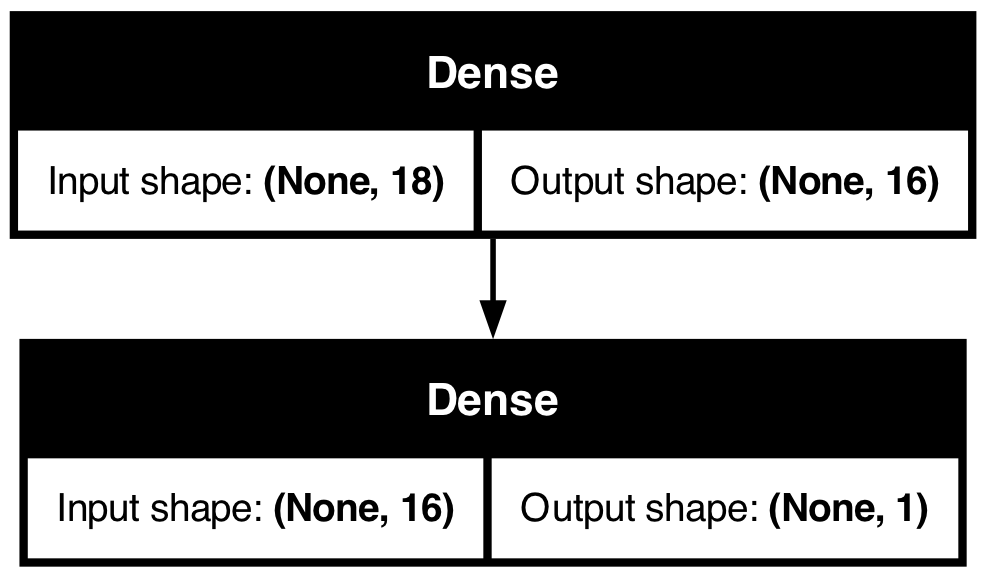

In [36]:
keras.utils.plot_model(model_sequential, show_shapes=True)

## loss function

In [58]:
model_sequential.compile(
            optimizer='adamW',
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## 10 epochs

In [60]:
x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")

In [61]:
model_sequential.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
df_churn.dtypes

SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure              float64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [63]:
history = model_sequential.fit(
            x_train,
            y_train,
            epochs=30,
            validation_data=(x_test, y_test)
        )


Epoch 1/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7994 - loss: 0.4174 - val_accuracy: 0.8148 - val_loss: 0.4024
Epoch 2/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.8001 - loss: 0.4186 - val_accuracy: 0.8148 - val_loss: 0.4024
Epoch 3/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.7998 - loss: 0.4180 - val_accuracy: 0.8126 - val_loss: 0.4052
Epoch 4/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7996 - loss: 0.4176 - val_accuracy: 0.8162 - val_loss: 0.4018
Epoch 5/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7982 - loss: 0.4170 - val_accuracy: 0.8183 - val_loss: 0.4023
Epoch 6/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.8024 - loss: 0.4170 - val_accuracy: 0.8155 - val_loss: 0.4023
Epoch 7/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.8014 - loss: 0.4165 - val_accuracy: 0.8176 - val_loss: 0.4030
Epoch 8/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.8019 - loss: 0.4169 - 

# confusion matrix

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


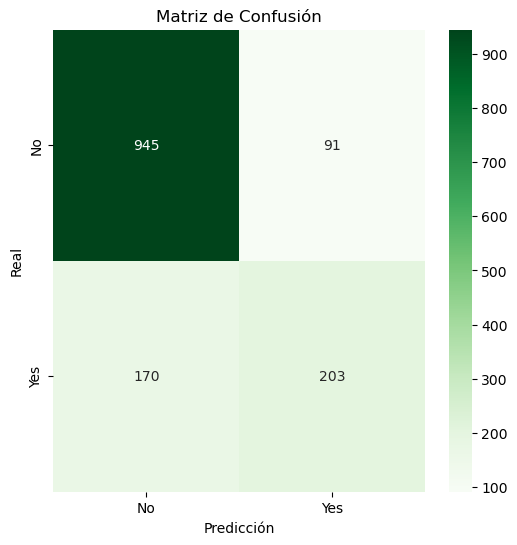

In [66]:
y_pred = (model_sequential.predict(x_test) > 0.5)  # Convertir las probabilidades a 0 o 1
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Metrci report

In [67]:
# metric report
report = classification_report(y_test, y_pred, target_names=["No Churn", "Churn"])

print(report)

              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1036
       Churn       0.69      0.54      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409



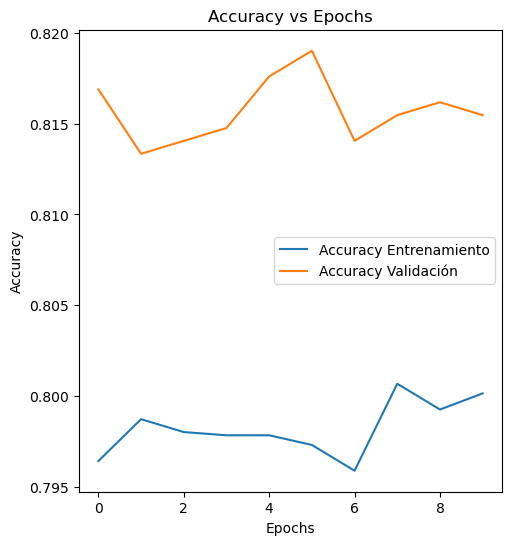

In [56]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy Validación')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

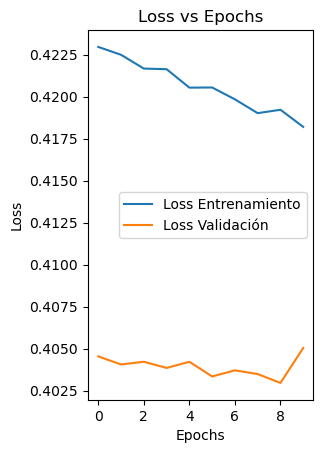

In [57]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss Validación')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Curva de Roc

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


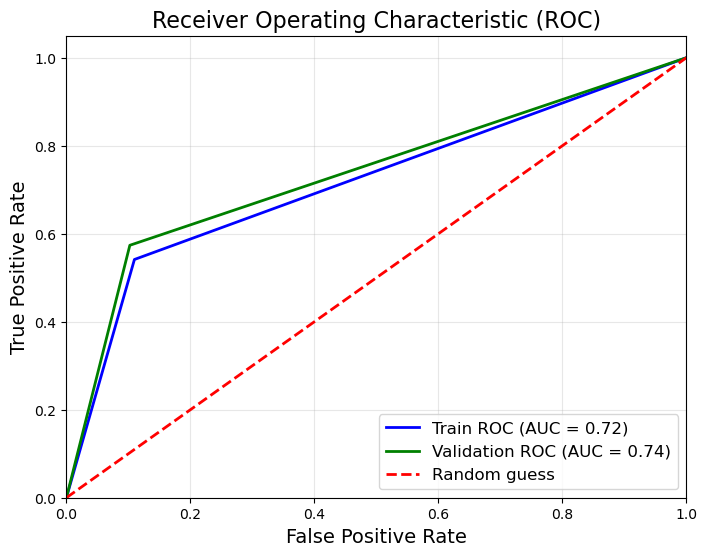

In [48]:
# Obtener las predicciones de probabilidades
y_pred_train = (model_sequential.predict(x_train) > 0.5)  # Convertir las probabilidades a 0 o 1

# Calcular las métricas de la curva ROC para entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Calcular las métricas de la curva ROC para validación
fpr_val, tpr_val, _ = roc_curve(y_test, y_pred)
roc_auc_val = auc(fpr_val, tpr_val)

# Graficar ambas curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', lw=2, label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()